In [40]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pylab as plt
import itertools as iter

import torch
import torch.nn as nn
import torch.optim as optim

from typing import List, Tuple
from tqdm import tqdm

In [5]:

headlines = pd.read_csv('abcnews-date-text.csv')['headline_text']

# Sequence of letters
Let's now take these headlines and grab sequences of letters out of them.

In [6]:
headlines[0]

'aba decides against community broadcasting licence'

In [13]:
def sliding_window(text:str) -> Tuple[str, str]:
    """Generates a sliding window of size 2 over the text

    Args:
        text (str): The text to generate the sliding window over

    Yields:
        str: A sliding window of size 2 over the text
    """
    for i in range(len(text)-1):
        yield text[i], text[i+1]

In [24]:
window = list(iter.chain(*[sliding_window(_) for _ in headlines[:10000]]))

mapping = {c: i for i, c in enumerate(pd.DataFrame(window)[0].unique())}
integers_in = np.array([mapping[w[0]] for w in window])
integers_out = np.array([mapping[w[1]] for w in window]).reshape(-1, 1)

In [29]:
integers_in.shape , integers_out.shape

((386880,), (386880, 1))

# Embedding layer

In [33]:
num_letters = len(mapping)

embedding = nn.Embedding(num_letters, 2)
model_emb = nn.Sequential(embedding)

input_tensor = torch.tensor(integers_in, dtype=torch.long)

# Pass the input tensor through the model
output_array = model_emb(input_tensor)

output_array.shape

torch.Size([386880, 2])

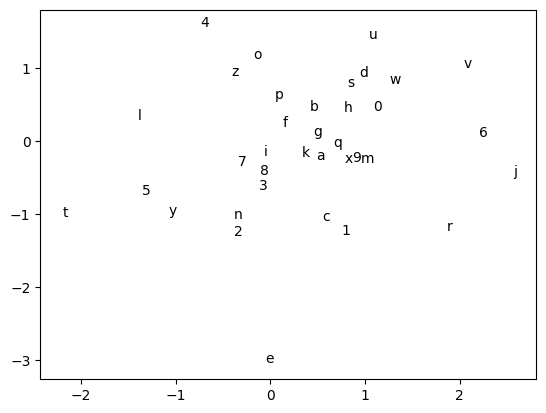

In [35]:
# Convert mapping values to a list and then to a numpy array
idx_to_calc = list(mapping.values())
idx_to_calc = np.array([idx_to_calc]).T

# Create a translator dictionary
translator = {v: k for k, v in mapping.items()}

# Convert idx_to_calc to a PyTorch tensor
idx_to_calc_tensor = torch.tensor(idx_to_calc, dtype=torch.long)

# Perform a forward pass through the model
with torch.no_grad():
    preds = model_emb(idx_to_calc_tensor)

# Convert predictions to numpy array for plotting
preds = preds.numpy()

# Plotting
plt.scatter(preds[:, 0, 0], preds[:, 0, 1], alpha=0)
for i, idx in enumerate(idx_to_calc):
    plt.text(preds[i, 0, 0], preds[i, 0, 1], translator[idx[0]])

plt.show()

# Mapping layers

In [43]:
# Check if MPS is available and set the device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Model
class ModelPred(nn.Module):
    def __init__(self, num_letters:int, embedding_dim:int):
        super().__init__()
        self.embedding = nn.Embedding(num_letters, embedding_dim)
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(embedding_dim, num_letters)

    def forward(self, x):
        x = self.embedding(x)
        x = self.flatten(x)
        x = self.dense(x)
        return x
    
# Parameters
num_letters = len(mapping)
embedding_dim = 2

# Instantiate the model
model_pred = ModelPred(num_letters, embedding_dim).to(device)
input_tensor = torch.tensor(integers_in, dtype=torch.long).to(device)
target_tensor = torch.tensor(integers_out, dtype=torch.long).squeeze().to(device)

# Define the optimizer
adam = optim.Adam(model_pred.parameters(), lr=0.01, betas=(0.9, 0.999), amsgrad=False)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Training loop
epochs = 30
batch_size = 500

for epoch in range(epochs):
    model_pred.train()
    epoch_loss = 0
    for i in tqdm(range(0, len(integers_in), batch_size), desc=f"Epoch {epoch+1}/{epochs}"):
        
        # Zero the parameter gradients
        adam.zero_grad()

        # Forward pass
        outputs = model_pred(input_tensor)

        # Calculate the loss
        loss = criterion(outputs, target_tensor)

        # Backward pass
        loss.backward()
        adam.step()

        epoch_loss += loss.item()

    if (epoch + 1) % 5 == 0:
        print(f'Epoch: {epoch+1}, Loss: {epoch_loss / len(integers_in):.4f}')

print('Finished Training')


Using device: mps


Epoch 5/30: 100%|██████████| 774/774 [01:31<00:00,  8.48it/s]


Epoch: 5, Loss: 0.0053


Epoch 10/30: 100%|██████████| 774/774 [01:30<00:00,  8.56it/s]


Epoch: 10, Loss: 0.0053


Epoch 15/30: 100%|██████████| 774/774 [02:37<00:00,  4.90it/s]  


Epoch: 15, Loss: 0.0053


Epoch 20/30: 100%|██████████| 774/774 [01:31<00:00,  8.47it/s]


Epoch: 20, Loss: 0.0053


Epoch 25/30: 100%|██████████| 774/774 [01:45<00:00,  7.32it/s]


Epoch: 25, Loss: 0.0053


Epoch 30/30: 100%|██████████| 774/774 [01:34<00:00,  8.17it/s]

Epoch: 30, Loss: 0.0053
Finished Training


In [44]:
# Save the model and optimizer state
torch.save({
    'epoch': epochs,
    'model_state_dict': model_pred.state_dict(),
    'optimizer_state_dict': adam.state_dict(),
    'loss': epoch_loss,
}, 'model_checkpoint.pth')

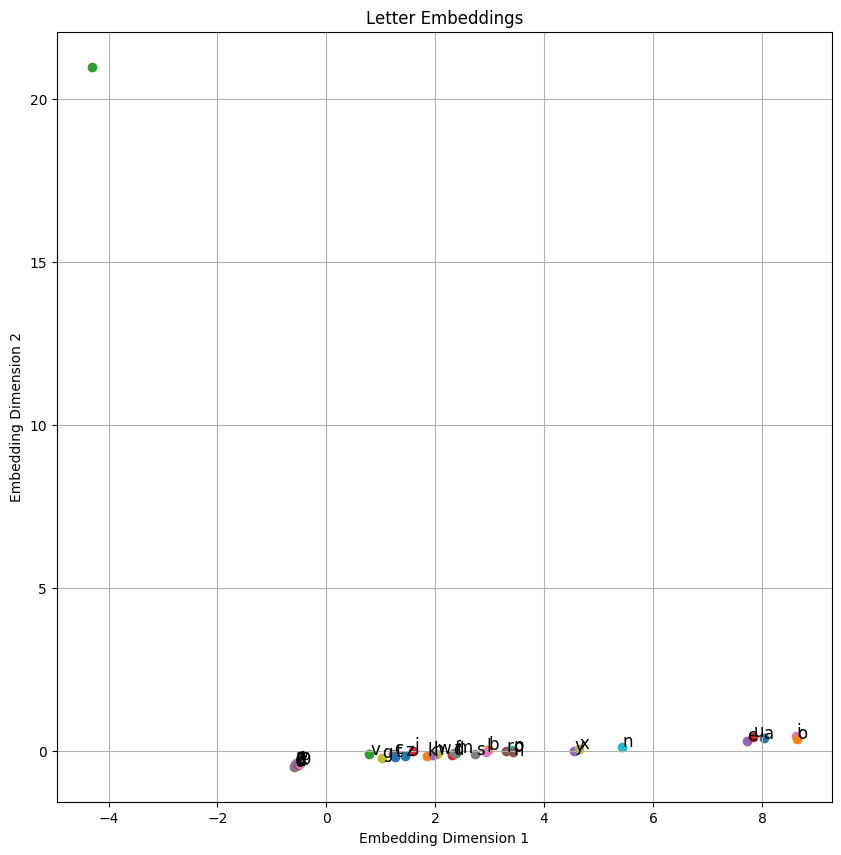

In [50]:
import torch
import matplotlib.pyplot as plt

# Assuming `mapping` is a dictionary that maps letters to indices
# Example: mapping = {'a': 0, 'b': 1, 'c': 2, ..., 'z': 25}
# Create a reverse mapping from indices to letters
reverse_mapping = {v: k for k, v in mapping.items()}

# Extract embeddings
embeddings = model_pred.embedding.weight.data.cpu().numpy()

# Plot embeddings
plt.figure(figsize=(10, 10))
for i in range(num_letters):
    plt.scatter(embeddings[i, 0], embeddings[i, 1])
    plt.text(embeddings[i, 0] + 0.01, embeddings[i, 1] + 0.01, reverse_mapping[i], fontsize=12)
plt.title("Letter Embeddings")
plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.grid(True)
plt.show()